# Tutorial to implement GAN using PyTorch
This is a simple example to grasp the concept of GAN framework. We will build our version from scratch afterward \
https://realpython.com/generative-adversarial-networks/#handwritten-digits-generator-with-a-gan

In [1]:
!nvidia-smi

Mon Dec  2 16:19:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

import math
import matplotlib.pyplot as plt
import torchvision

In [3]:
# Enable GPU if possible

device = ""
device = torch.device("cuda:0") # We use 0 to specify the first GPU
print("Using GPU")


# Transform MNIST in tensor with normalized values
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

# Separate tensor into batch for PyTorch
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Using GPU
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Show some samples

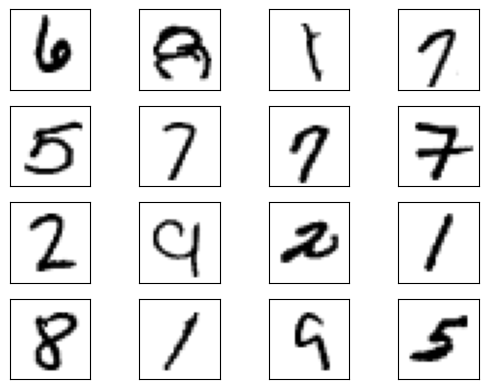

In [4]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Implement Generator & Discriminator

In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(784, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output


class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(100, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 784),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

### Hyperparameters

In [6]:
lr = 0.0001
num_epochs = 50
loss_function = torch.nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

### Train models using GAN framework

Epoch: 0 Loss D.: 0.5332594513893127
Epoch: 0 Loss G.: 0.542896032333374
Epoch: 1 Loss D.: 0.006774374283850193
Epoch: 1 Loss G.: 7.824701309204102
Epoch: 2 Loss D.: 0.030418789014220238
Epoch: 2 Loss G.: 4.518537521362305
Epoch: 3 Loss D.: 0.01064208522439003
Epoch: 3 Loss G.: 4.911609649658203
Epoch: 4 Loss D.: 0.038849860429763794
Epoch: 4 Loss G.: 5.024284839630127
Epoch: 5 Loss D.: 0.07987956702709198
Epoch: 5 Loss G.: 4.429028511047363
Epoch: 6 Loss D.: 0.11945639550685883
Epoch: 6 Loss G.: 2.8722689151763916
Epoch: 7 Loss D.: 0.057545632123947144
Epoch: 7 Loss G.: 4.780658721923828
Epoch: 8 Loss D.: 0.09594382345676422
Epoch: 8 Loss G.: 3.6534862518310547
Epoch: 9 Loss D.: 0.10912162065505981
Epoch: 9 Loss G.: 3.9053330421447754
Epoch: 10 Loss D.: 0.3778191804885864
Epoch: 10 Loss G.: 3.0257740020751953
Epoch: 11 Loss D.: 0.14550533890724182
Epoch: 11 Loss G.: 2.8599014282226562
Epoch: 12 Loss D.: 0.23194573819637299
Epoch: 12 Loss G.: 2.4287266731262207
Epoch: 13 Loss D.: 0.308

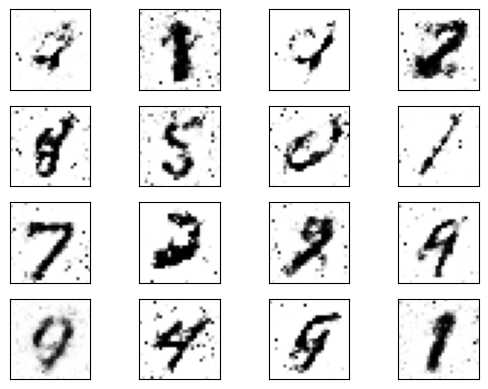

In [7]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


# Print generated samples
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

This is a simple example, but it helps understanding the GAN framework.
Next steps are to implement a more generic framework in a OOP approach to test multiple 'from scratch' models efficiently.

Also, it seems like learning digits from 1 to 9 results in a noisier generation than focusing on only one digit.